In [1]:
import pandas as pd
import random
import pulp
import time


## 1. Extracción y calculo de tasas
En esta sección se extrae la información de demanda dada por el modelo de proyección. A partir de esta se asignan las tasas de lambda


In [ ]:
df = pd.read_excel("Datos Demanda.xlsx")

# Extraer los valores de la columna 5 (índice 4, ya que los índices comienzan en 0)
Tasa_Pradera_1 = df["Tasa Pradera Sentido 1"].tolist()
Tasa_Pradera_2 = df["Tasa Pradera Sentido 2"].tolist()
tasas= [[Tasa_Pradera_1[i], Tasa_Pradera_2[i]] for i in range(len(Tasa_Pradera_1))]
print(tasas)

[[1.9, 1.9], [2.1, 2.1], [2.2, 2.2], [2.3, 2.3], [2.5, 2.5], [2.6, 2.6], [2.7, 2.7], [2.8, 2.8], [2.9, 2.9], [3.1, 3.1], [3.1, 3.1], [3.2, 3.2], [3.3, 3.3], [3.4, 3.4], [3.4, 3.4], [3.4, 3.4], [3.5, 3.5], [3.5, 3.5], [3.5, 3.5], [3.5, 3.5], [3.5, 3.5], [3.5, 3.5], [3.5, 3.5], [3.5, 3.5], [3.5, 3.5], [3.4, 3.4], [3.4, 3.4], [3.4, 3.4], [3.4, 3.4], [3.4, 3.4], [3.3, 3.3], [3.3, 3.3], [3.3, 3.3], [3.3, 3.3], [3.3, 3.3], [3.3, 3.3], [3.3, 3.3], [3.3, 3.3], [3.3, 3.3], [3.3, 3.3], [3.3, 3.3], [3.3, 3.3], [3.3, 3.3], [3.3, 3.3], [3.3, 3.3], [3.3, 3.3], [3.3, 3.3], [3.4, 3.4], [3.4, 3.4], [3.4, 3.4], [3.4, 3.4], [3.4, 3.4], [3.4, 3.4], [3.4, 3.4], [3.4, 3.4], [3.5, 3.5], [3.5, 3.5], [3.5, 3.5], [3.5, 3.5], [3.6, 3.6], [3.6, 3.6], [3.6, 3.6], [3.6, 3.6], [3.6, 3.6], [3.7, 3.7], [3.7, 3.7], [3.7, 3.7], [3.7, 3.7], [3.7, 3.7], [3.7, 3.7], [3.7, 3.7], [3.7, 3.7], [3.7, 3.7], [3.7, 3.7], [3.6, 3.6], [3.6, 3.6], [3.5, 3.5], [3.5, 3.5], [3.4, 3.4], [3.3, 3.3], [3.2, 3.2], [3.1, 3.1], [3.0, 3.0], [2.


## 2. Implementación del Modelo
En esta sección la formulación matematica es planteada en PULP

In [ ]:

start_time = time.time()
# Parámetros
m = 96
n=[7,7]
alpha = 10
t_ruta = 40
t_min = 5
h_min = 5
h_max = 15
C = 45
F=2

# Crear el problema de optimización
prob = pulp.LpProblem("Despacho_de_Buses", pulp.LpMinimize)

# Variables de decisión
x = pulp.LpVariable.dicts("x", ((i, t,f) for f in range(F)for i in range(n[f]) for t in range(m)), cat='Binary')
b = pulp.LpVariable.dicts("b", ((t,f) for t in range(m) for f in range(F) ), lowBound=0)
w = pulp.LpVariable.dicts("w", ((t,f)for t in range(m) for f in range(F) ), lowBound=0)
delta = pulp.LpVariable.dicts("delta", ((t,f) for t in range(m) for f in range(F)), lowBound=0)

# Función objetivo
prob += pulp.lpSum(w[t,f] for t in range (m) for f in range(F)), "Minimize_total_waiting_passengers"

# Restricciones
for t in range(m):
  for f in range(F):
      prob+=delta[t,f]== tasas[t][f]*alpha


# Inicialización del primer intervalo
for f in range(F):
    prob += w[0,f] == delta[0,f]

# Restricción de pasajeros esperando en intervalos t > 0
for t in range(1, m):
  for f in range(F):
      prob += w[t,f] == w[t - 1,f]+ delta[t - 1,f] - b[t,f]
for t in range(m):
  for f in range(F):
      prob+=pulp.lpSum(x[i,t,f]for i in range(n[f]))<=1

# Capacidad de abordaje en cada intervalo
for t in range(m):
  for f in range(F):
     prob += b[t,f] <= pulp.lpSum(x[i,t,f] * C for i in range(n[f]))

# Restringir los intervalos entre tiempo mínimo y máximo si se despacha en `t`
for f in range(F):
  for i in range(n[f]):  # Para cada bus
     for t in range(m):  # Para cada intervalo `t`
         # Calcula el número de intervalos que representan los tiempos mínimos y máximos
         tiempo_min_intervalos = int((2*t_ruta + 2*t_min) / alpha)
         tiempo_max_intervalos = int((2*t_ruta + 2*t_min+2*h_max) / alpha)

         # Restringir los intervalos entre tiempo mínimo y máximo si se despacha en `t`
         for k in range(1, tiempo_min_intervalos):
            if t + k < m:  # Asegúrate de no exceder el número de intervalos
                prob += x[i, t,f] + x[i, t + k,f] <= 1

        # Asegurar que el despacho se produzca en el rango permitido
         if t - tiempo_max_intervalos >=0:
            prob += pulp.lpSum(x[i, t - k,f] for k in range(tiempo_min_intervalos, tiempo_max_intervalos + 1)) >= x[i, t,f]
for f in range(F):  # Para cada sentido
    for i in range(n[f]):  # Para cada bus
        for t in range(m):  # Para cada intervalo `t`
            # Si el bus i se despacha en el intervalo t, asegurarse de que todos los buses anteriores ya se han despachado
            if i > 0:  # Asegúrate de no evaluar el primer bus
                prob += pulp.lpSum(x[j, t_j, f] for j in range(i) for t_j in range(t + 1)) >= x[i, t, f]
for f in range(F):
  for i in range(1, n[f]):  # Para cada bus `i`, comenzando desde el segundo (ya que `j` es el anterior)
      j = i - 1  # `j` es el bus anterior al bus `i`
      for t in range(m):  # Para cada intervalo `t`
         # Calcula los intervalos para `h_min` y `h_max`
         min_intervalos = int(h_min / alpha)
         max_intervalos = int(h_max / alpha)

         # Asegurar que si el bus `i` está en el intervalo `t`, el bus `j` se asignó en algún intervalo entre [t - max_intervalos, t - min_intervalos]
         if t - max_intervalos >= 0:  # Verifica que el rango esté dentro de los límites de `m`
            # Si el bus `i` se despacha en `t`, el bus `j` debió ser despachado en algún intervalo entre `t - max_intervalos` y `t - min_intervalos`
            prob += x[i, t,f] <= pulp.lpSum(x[j, t - k,f] for k in range(min_intervalos, max_intervalos + 1))
for f in range(F):
  prob += pulp.lpSum(x[0, t,f] for t in range(int(h_min/alpha), int(h_max/alpha) + 1)) >= 1

t_ruta_intervals = int(t_ruta / alpha)

#Calcular el límite de intervalos
t_limite = m - (t_ruta_intervals)
for f in range(F):
  for t in range(t_limite, m):
    for i in range(n[f]):
        prob += x[i, t,f] == 0

iteration_count = 0

# Definición de un solucionador personalizado
class CustomSolver(pulp.PULP_CBC_CMD):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __call__(self, *args, **kwargs):
        global iteration_count
        iteration_count += 1
        return super().__call__(*args, **kwargs)

# Resolviendo el problema con el solucionador personalizado
prob.solve()  # Activa la salida de mensajes
# Resultados
print("Estado de la solución:", pulp.LpStatus[prob.status])
print("Cantidad mínima de pasajeros esperando:", pulp.value(prob.objective))
print(f"Número de iteraciones realizadas: {iteration_count}")


# Resultados
print("Estado de la solución:", pulp.LpStatus[prob.status])
print("Cantidad mínima de pasajeros esperando:", pulp.value(prob.objective))
print("\nAsignaciones de servicios:")
for f in range(F):
    for i in range(n[f]):
      for t in range(m):
          if pulp.value(x[ i, t,f]) == 1:
             print(f" Bus {i}, Intervalo {t}, Sentido{f}")

print("\nPasajeros abordando por intervalo y sentido:")
for t in range(m):
  for f in range(F):
     print(f"Intervalo {t}, Sentido{f}: {pulp.value(b[t,f])}")
print("\nPasajeros que llegaron:")
for t in range(m):
  for f in range(F):
     print(f"Intervalo {t}, Sentido{f}, : {pulp.value(delta[t,f])}")

print("\nPasajeros esperando por intervalo y sentido:")
for t in range(m):
  for f in range(F):
     print(f"Intervalo {t}, Sentido{f}: {pulp.value(w[t,f])}")
end_time = time.time()

print("Tiempo de CPU: {:.2f} segundos".format(end_time - start_time))


Estado de la solución: Optimal
Cantidad mínima de pasajeros esperando: 6282.0
Número de iteraciones realizadas: 0
Estado de la solución: Optimal
Cantidad mínima de pasajeros esperando: 6282.0

Asignaciones de servicios:
 Bus 0, Intervalo 0, Sentido0
 Bus 0, Intervalo 9, Sentido0
 Bus 0, Intervalo 18, Sentido0
 Bus 0, Intervalo 27, Sentido0
 Bus 0, Intervalo 36, Sentido0
 Bus 0, Intervalo 45, Sentido0
 Bus 0, Intervalo 54, Sentido0
 Bus 0, Intervalo 63, Sentido0
 Bus 0, Intervalo 72, Sentido0
 Bus 0, Intervalo 81, Sentido0
 Bus 0, Intervalo 90, Sentido0
 Bus 1, Intervalo 1, Sentido0
 Bus 1, Intervalo 10, Sentido0
 Bus 1, Intervalo 19, Sentido0
 Bus 1, Intervalo 28, Sentido0
 Bus 1, Intervalo 37, Sentido0
 Bus 1, Intervalo 46, Sentido0
 Bus 1, Intervalo 55, Sentido0
 Bus 1, Intervalo 64, Sentido0
 Bus 1, Intervalo 73, Sentido0
 Bus 1, Intervalo 82, Sentido0
 Bus 1, Intervalo 91, Sentido0
 Bus 2, Intervalo 2, Sentido0
 Bus 2, Intervalo 11, Sentido0
 Bus 2, Intervalo 20, Sentido0
 Bus 2, I


## 3. Visualización de resultados
En esta sección se grafican las tres variables de decisión del modelo, ademas de metricas de eficiencia computacional 

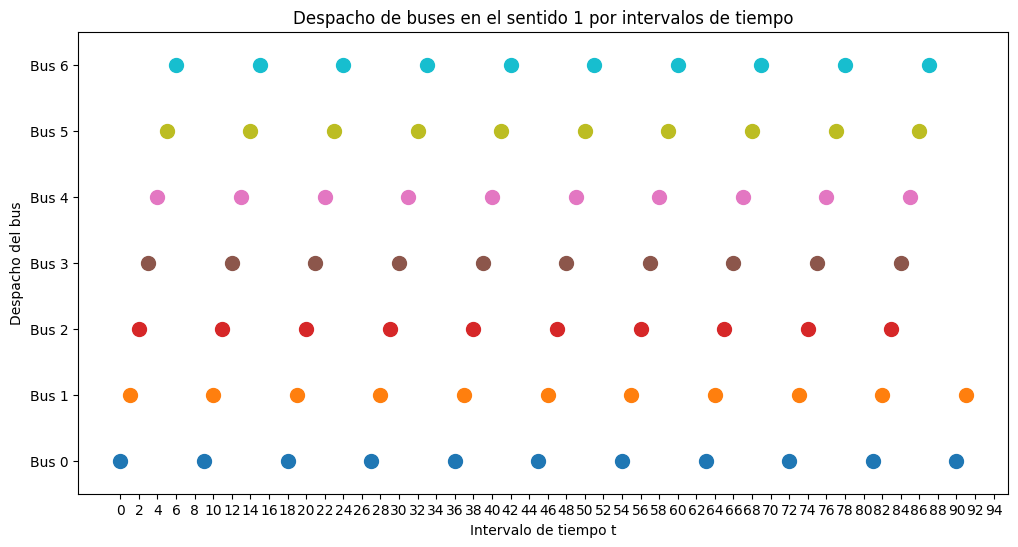

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Parámetros de la gráfica
intervalos = list(range(m))  # Intervalos en el eje horizontal
colors = plt.cm.tab10(np.linspace(0, 1, n[0]))  # Colores para cada bus en el sentido f=0

# Graficar solo el sentido f=0
plt.figure(figsize=(12, 6))

for i in range(n[0]):  # Solo buses en el sentido f=0
    # Obtén el valor de cada variable de PuLP en x para sentido 0
    despachos = [x[(i, t, 0)].value() for t in intervalos]  # Extrae los valores de 0 o 1

    # Filtra solo los intervalos donde hay despacho (valor 1)
    intervalos_despachados = [t for t in intervalos if despachos[t] == 1]

    # Graficar los puntos para los intervalos despachados en la posición vertical del bus
    plt.scatter(intervalos_despachados, [i] * len(intervalos_despachados), color=colors[i], label=f'Bus {i}', s=100)

# Etiquetas y leyenda
plt.yticks(range(n[0]), [f'Bus {i}' for i in range(n[0])])  # Etiquetas del eje y
plt.xticks(range(0, m, 2))
plt.xlabel("Intervalo de tiempo t")
plt.ylabel("Despacho del bus")
plt.title("Despacho de buses en el sentido 1 por intervalos de tiempo")
plt.ylim(-0.5, n[0] - 0.5)  # Ajustar límites del eje y
plt.show()



# Mostrar la gráfica
plt.show()

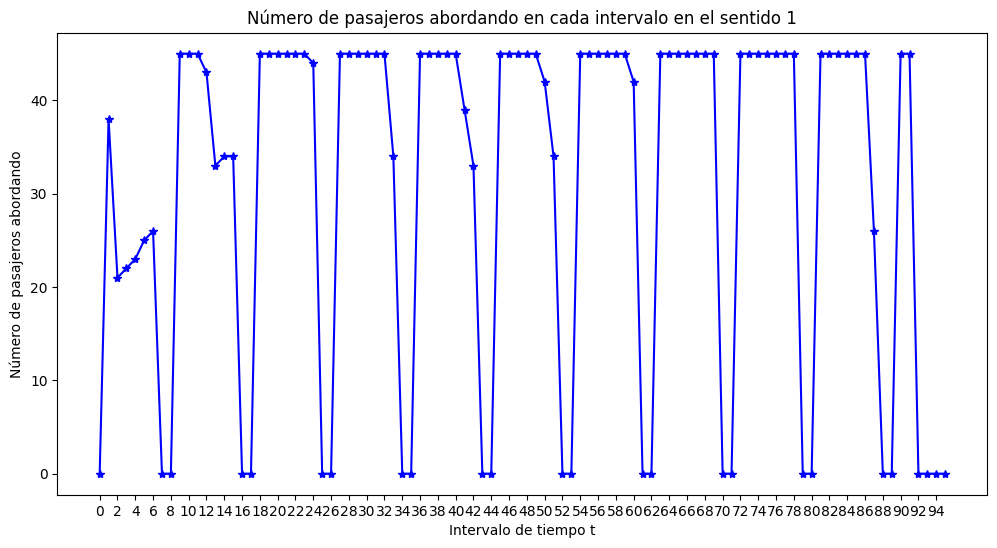

In [77]:
pasajeros_abordando_0 = [b[(t, 0)].value() for t in range(m)]

# Crear la gráfica
plt.figure(figsize=(12, 6))
plt.plot(range(m), pasajeros_abordando_0, linestyle='-', marker="*", color='b', label='Pasajeros abordando (f=0)')

# Configuración de ejes y etiquetas
plt.xticks(range(0, m, 2))  # Mostrar etiquetas en el eje x de dos en dos
plt.xlabel("Intervalo de tiempo t")
plt.ylabel("Número de pasajeros abordando")
plt.title("Número de pasajeros abordando en cada intervalo en el sentido 1")

# Mostrar la gráfica
plt.show()

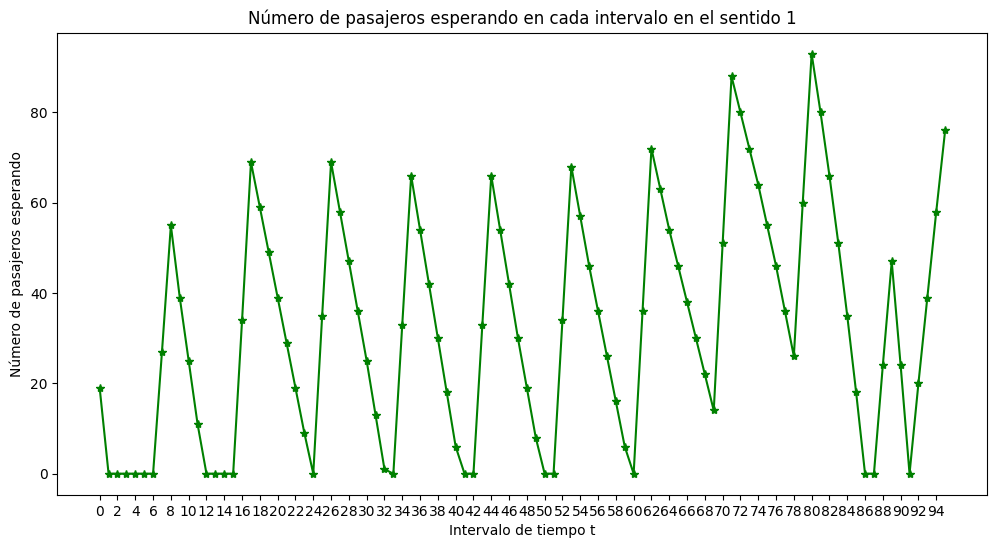

In [78]:
pasajeros_esperando_0 = [w[(t, 0)].value() for t in range(m)]

# Crear la gráfica
plt.figure(figsize=(12, 6))
plt.plot(range(m), pasajeros_esperando_0, linestyle='-', marker="*",color='g', label='Pasajeros abordando (f=0)')

# Configuración de ejes y etiquetas
plt.xticks(range(0, m, 2))  # Mostrar etiquetas en el eje x de dos en dos
plt.xlabel("Intervalo de tiempo t")
plt.ylabel("Número de pasajeros esperando")
plt.title("Número de pasajeros esperando en cada intervalo en el sentido 1")

# Mostrar la gráfica
plt.show()

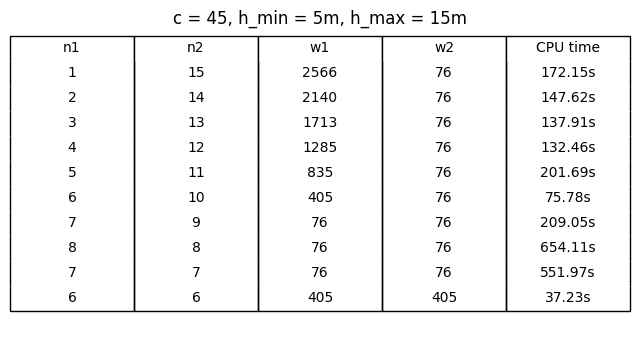

In [79]:
import matplotlib.pyplot as plt

# Datos para la tabla
data = [
    [1, 15, 2566, 76, "172.15s"],
    [2, 14, 2140, 76, "147.62s"],
    [3, 13, 1713, 76, "137.91s"],
    [4, 12, 1285, 76, "132.46s"],
    [5,11,835,76,"201.69s"],
    [6,10,405,76,"75.78s"],
    [7,9,76,76,"209.05s"],
    [8,8,76,76,"654.11s"],
    [7,7,76,76,"551.97s"],
    [6,6,405,405,"37.23s"]
]

# Encabezados de las columnas
column_labels = ["n1", "n2", "w1", "w2", "CPU time"]

# Crear la figura y la tabla
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis("off")  # Ocultar los ejes
table = ax.table(cellText=data, colLabels=column_labels, cellLoc='center', loc='center')
# Ajustar el estilo de las líneas
for i in range(len(data) + 1):  # +1 para incluir la fila de encabezado
    for j in range(len(column_labels)):
        cell = table[(i, j)]
        # Para la primera fila (encabezado), mostrar superior y verticales
        if i == 0:
            cell.visible_edges = 'LTR'  # Borde izquierdo, derecho y superior
        # Para la última fila, mostrar inferior y verticales
        elif i == len(data):
            cell.visible_edges = 'LBR'  # Borde izquierdo, derecho y inferior
        # Para las filas intermedias, solo bordes verticales
        else:
            cell.visible_edges = 'LR'

# Escalar la tabla para mejor visualización
table.scale(1, 1.5)  # Escalar la tabla si es necesario para mejor visualización
plt.text(0.5, 1, "c = 45, h_min = 5m, h_max = 15m", ha='center', va='center', fontsize=12, transform=ax.transAxes)
# Mostrar la tabla
plt.show()